# Two-Level: Weak Pulse through Few Atoms with Decay

## Define the Problem

In [1]:
mb_solve_json = """
{
  "atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 1.0
      }
    ],
    "energies": [],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "detuning": 0.0,
        "detuning_positive": true,
        "label": "probe",
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl": 1.0,
          "centre": 0.0,
          "fwhm": 1.0
        },
        "rabi_freq_t_func": "gaussian"
      }
    ],
    "num_states": 2
  },
  "t_min": -2.0,
  "t_max": 10.0,
  "t_steps": 1000,
  "z_min": -0.2,
  "z_max": 1.2,
  "z_steps": 100,
  "z_steps_inner": 1,
  "num_density_z_func": "square",
  "num_density_z_args": {
    "on": 0.0,
    "off": 1.0,
    "ampl": 1.0
  },
  "interaction_strengths": [
    1.0
  ],
  "velocity_classes": null,
  "method": "mesolve",
  "opts": {},
  "savefile": "qu/mb-solve-two-weak-pulse-few-atoms-decay" 
}
"""

In [2]:
from maxwellbloch import mb_solve
mb_solve_00 = mb_solve.MBSolve().from_json_str(mb_solve_json)

## Solve the Problem

In [3]:
%time Omegas_zt, states_zt = mb_solve_00.mbsolve(recalc=False)

Loaded tuple object.
CPU times: user 10.1 ms, sys: 17.7 ms, total: 27.8 ms
Wall time: 33.8 ms


## Plot Output

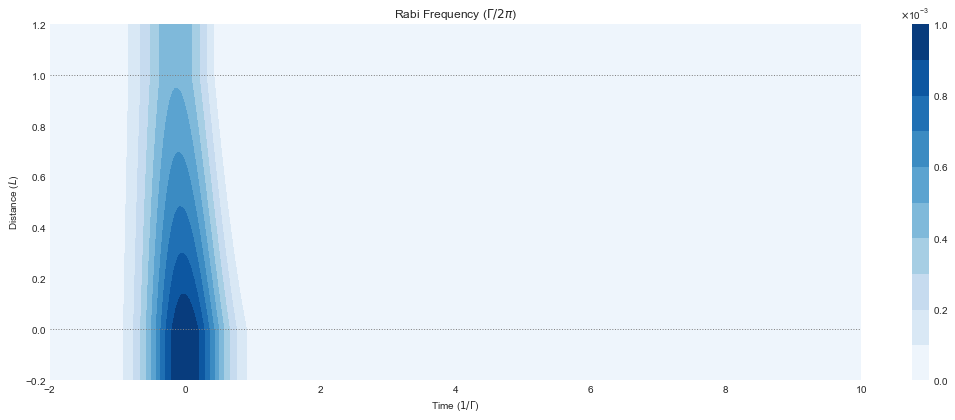

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

sns.set_style('darkgrid')
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mb_solve_00.tlist, mb_solve_00.zlist, 
                 np.abs(mb_solve_00.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf)
plt.savefig('images/mb-solve-two-weak-pulse-few-atoms-decay.png')

## Pulse Arrival Time

In [5]:
profile_in = np.abs(mb_solve_00.Omegas_zt[0, 0])
peak_in = mb_solve_00.tlist[np.argmax(profile_in)]
print(peak_in)

0.004


In [6]:
profile_out = np.abs(mb_solve_00.Omegas_zt[0, -1])
peak_out = mb_solve_00.tlist[np.argmax(profile_out)]
print(peak_out)

-0.14


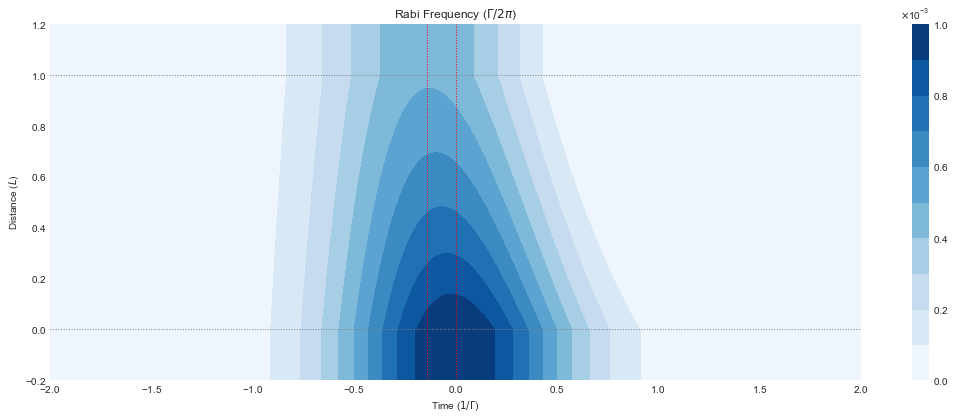

In [7]:
fig = plt.figure(2, figsize=(16, 6))
ax = fig.add_subplot(111)
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mb_solve_00.tlist, mb_solve_00.zlist, 
                 np.abs(mb_solve_00.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
for x in [peak_in, peak_out]:
    ax.axvline(x, c='red', lw=1.0, ls='dotted')
ax.set_xlim(-2, 2)
plt.colorbar(cf);

In [8]:
pulse_width = 1.0
pulse_delay_ratio = (peak_out - peak_in)/pulse_width

In [9]:
print('The pulse is advanced by {:.3f} pulse widths'.format(pulse_delay_ratio))

The pulse is advanced by -0.144 pulse widths


## Fixed Frame

In [10]:
from maxwellbloch import fixed

In [11]:
speed_of_light = 0.2 # [L Γ]

tlist_fixed_frame = fixed.t_list(mb_solve_00, speed_of_light)
field_fixed_frame = fixed.rabi_freq_abs(mb_solve_00, 0, speed_of_light, interp_kind='cubic')

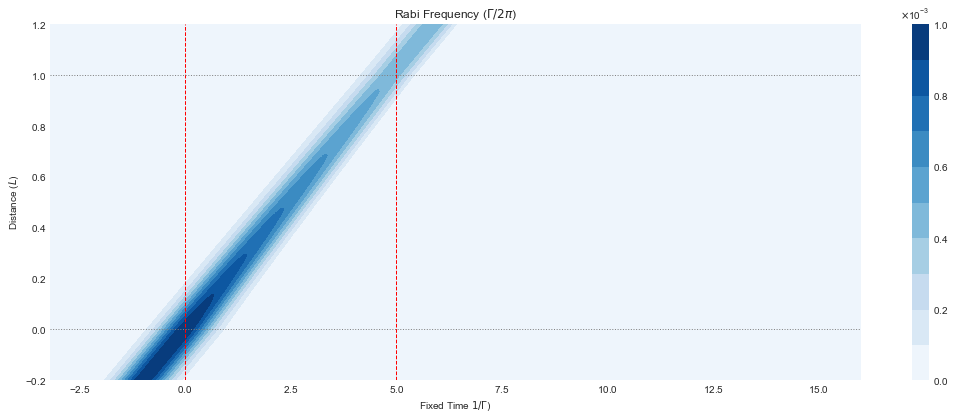

In [12]:
fig = plt.figure(2, figsize=(16, 6))
ax = fig.add_subplot(111)
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(tlist_fixed_frame, mb_solve_00.zlist, 
                 np.abs(field_fixed_frame/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Blues)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Fixed Time $1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for x in [0.0, 1/speed_of_light]:
    ax.axvline(x, c='red', lw=1.0, ls='dashed')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

## Spectral Analysis

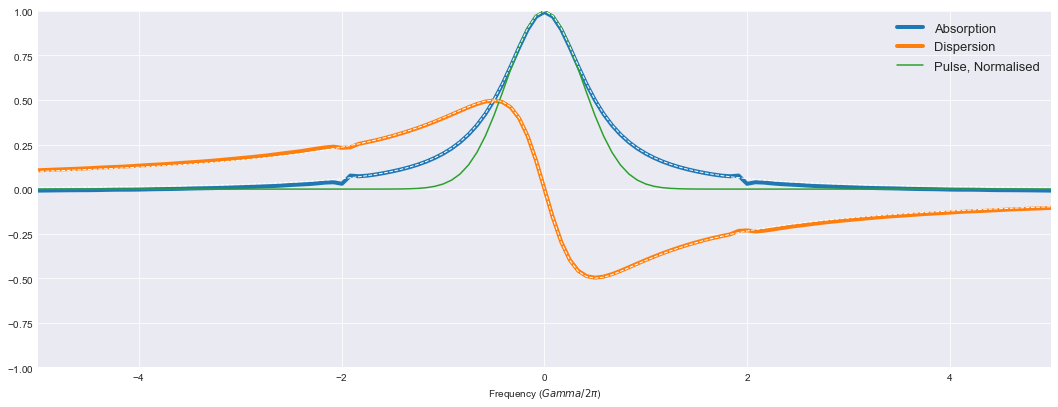

In [13]:
from maxwellbloch import spectral

freq_list = spectral.freq_list(mb_solve_00)
rabi_freq_abs_0 = np.abs(spectral.rabi_freq(mb_solve_00, 0))[0]


absorption_linear_known = spectral.absorption_two_linear_known(freq_list, 1.0, 1.0)
dispersion_linear_known = spectral.dispersion_two_linear_known(freq_list, 1.0, 1.0)

fig = plt.figure(4, figsize=(16, 6))
ax = fig.add_subplot(111)

ax.plot(freq_list, spectral.absorption(mb_solve_00, 0, -1), 
        label='Absorption', lw=4.0)
ax.plot(freq_list, spectral.dispersion(mb_solve_00, 0, -1), 
        label='Dispersion', lw=4.0)

ax.plot(freq_list, 
        rabi_freq_abs_0/np.max(rabi_freq_abs_0),
        label='Pulse, Normalised')

ax.plot(freq_list, absorption_linear_known, ls='dashed', c='white', lw=1.0)
ax.plot(freq_list, dispersion_linear_known, ls='dashed', c='white', lw=1.0)

ax.set_xlim(-5.0, 5.0)
ax.set_ylim(-1.0, 1.0)

ax.set_xlabel('Frequency ($Gamma / 2\pi$)')

ax.legend();